# Off-target analysis
In this notebook we investigate whether the unexpected fitness defect produced by some guide RNAs can be due to off-targets blocking the expression of essential or fitness genes.

- **guide**: guide RNA sequence
- **pos**: position in the genome
- **ori**: orientation of the guide with regard to the chromosome
- **gene**: name of gene targeted (if the PAM is within a gene)
- **coding**: orientation with regard to the gene (coding == True means that the guide targets the coding strands, i.e. the non-template strand, which is the orientation giving the strongest repression
- **fit18**: fitness measured in strain LC-E18 (log2FC)
- **fit75**: fitness measured in strain LC-E75 (log2FC)
- **seq**: 60bp surounding the target


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
font = {'size'   : 10}
matplotlib.rc('font', **font)

data=pd.read_csv("screen_data.csv",sep=",")

data.index=data.guide.values
data.head()

guide  gene essential      pos ori  \
AAAAAACCTGCTGGTGAGGC  AAAAAACCTGCTGGTGAGGC   NaN       NaN  2202483   -   
AAAAAACGTATTCGCTTGCA  AAAAAACGTATTCGCTTGCA  curA     False  1517891   +   
AAAAAAGCGCACTTTTTGAC  AAAAAAGCGCACTTTTTGAC   NaN       NaN  1919717   +   
AAAAAAGCGGTGACTTACGA  AAAAAAGCGGTGACTTACGA  bglA     False  3042929   +   
AAAAAATCTGCCCGTGTCGT  AAAAAATCTGCCCGTGTCGT  gyrA      True  2337231   -   

                     coding     fit18     fit75  ntargets  \
AAAAAACCTGCTGGTGAGGC    NaN -4.850012 -1.437546         1   
AAAAAACGTATTCGCTTGCA  False -0.094026 -0.100313         1   
AAAAAAGCGCACTTTTTGAC    NaN -1.109310 -0.246740         1   
AAAAAAGCGGTGACTTACGA  False -1.328831 -0.905068         1   
AAAAAATCTGCCCGTGTCGT  False -0.840373 -0.598858         1   

                                                                    seq  
AAAAAACCTGCTGGTGAGGC  AAAGCAGATCACAGTAAATAAAAAAACCTGCTGGTGAGGCAGGTTC...  
AAAAAACGTATTCGCTTGCA  TGTTGATGGCTACAGTGCTGAAAAAACGTATTCGCTTGCAAGGTTT...  
AAAAAAGCGCACTTTTTGAC  GTAACGCCTGACAGCGCACAAAAAAAGCGCACTTTTTGACTGGCAC...  
AAAAAAGCGGTGACTTACGA  GCGCCCATATCGAAGAGATGAAAAAAGCGGTGACTTACGATGGCGT...  
AAAAAATCTGCCCGTGTCGT  ATGACTGGAACAAAGCCTATAAAAAATCTGCCCGTGTCGTTGGTGA...

Surprisingly, we observed a high variability of fitness effects between guide RNAs targeting nearby positions in the same orientation (Fig. 2a). These effects are reproducible between 3 independent experiments, suggesting that they are not the product of experimental noise, but a real biological effect. In particular guides binding to the template strand of non-essential genes are not expected to be depleted from the library, but in fact 7% of these guides (2499/36111) produce a strong fitness defect (log2FC < -3.5, see methods), accounting for 34% of all guides producing a strong fitness defect (Supplementary Table 3). 

In [2]:
# We arbitrarily choose a threshold below which guides are considered to produce a strong fitness defects:
threshold=-3.5
mask=data.ntargets==1
contigency=pd.crosstab(data[mask].essential,[data[mask].coding, data[mask].fit18<threshold],margins=True)
#contigency.to_excel("contigency_LC-E18.xls")
print(contigency)
#print()
#print(contigency/contigency.loc["All","All"].values[0])

coding     False         True          All
fit18      False  True  False  True       
essential                                 
False      33612  2499  25989  2694  64794
True        2628   351    701  1834   5514
All        36240  2850  26690  4528  70308


In [3]:
flt=(data.ntargets==1) & (data["fit18"]<threshold)
contigency=pd.crosstab(data[flt].essential,data[flt].coding,margins=True)
print(contigency)
print()
print(contigency/contigency.loc["All","All"])

coding     False  True   All
essential                   
False       2499  2694  5193
True         351  1834  2185
All         2850  4528  7378

coding        False      True       All
essential                              
False      0.338710  0.365140  0.703849
True       0.047574  0.248577  0.296151
All        0.386284  0.613716  1.000000


In the new screen the number of guides producing a strong fitness defect (log2FC < -3.5) while targeting the template strand of non-essential genes dropped from 2498 to 532.

In [4]:
flt=(data.ntargets==1) & (data["fit75"]<threshold)
contigency=pd.crosstab(data[flt].essential,data[flt].coding,margins=True)
print(contigency)
print()
print(contigency/contigency.loc["All","All"])

coding     False  True   All
essential                   
False        532  1000  1532
True         158  1696  1854
All          690  2696  3386

coding        False      True       All
essential                              
False      0.157118  0.295334  0.452451
True       0.046663  0.500886  0.547549
All        0.203780  0.796220  1.000000


We use a regression tree to identify regions where guides consistently produce a fitness defect. Off-targets in these regions are likely to be deleterious.

In [5]:
from sklearn.tree import DecisionTreeRegressor

X_ori=(data[["ori"]]=="+").values
X_pos=data[["pos"]].values
Y = data["fit18"].values.astype(np.float32)

reg=DecisionTreeRegressor(criterion='mse', splitter='best', 
                               max_depth=None, min_samples_split=5, 
                               min_samples_leaf=5, min_weight_fraction_leaf=0.0, 
                               max_features=None, random_state=None, max_leaf_nodes=400, presort=False)

#fit on position and ori only
X=np.concatenate((X_ori,X_pos),axis=1)
reg.fit(X,Y)
print(reg.score(X,Y))

0.379007653349


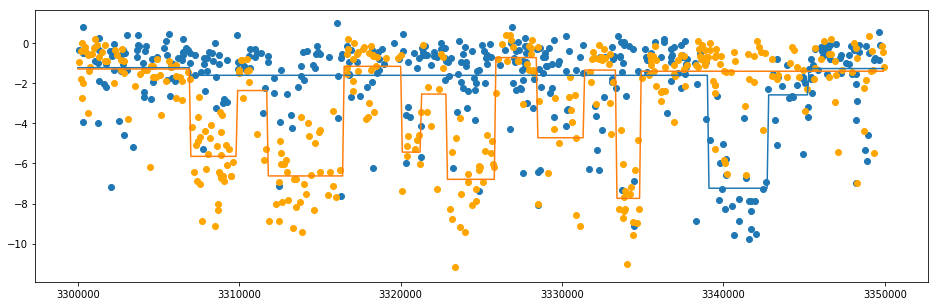

In [6]:
#left, right = 10000, 20000
left, right = (int(3.3e6), int(3.35e6))
fig, ax = plt.subplots(1,1,figsize=(16,5))
Xplus=X_pos[(X_pos>left)*(X_pos<right)*np.logical_not(X_ori).reshape(-1,1)]
Yplus=Y[((X_pos>left)*(X_pos<right)*np.logical_not(X_ori).reshape(-1,1))[:,0]]
ax.scatter(Xplus,Yplus)
r=np.arange(left,right,100)
rplus=np.array([np.zeros(len(r)),r]).T
ax.plot(r,reg.predict(rplus))

Xminus=X_pos[(X_pos>left)*(X_pos<right)*X_ori.reshape(-1,1)]
Yminus=Y[((X_pos>left)*(X_pos<right)*X_ori.reshape(-1,1))[:,0]]
ax.scatter(Xminus,Yminus,c="orange")
r=np.arange(left,right,100)
rplus=np.array([np.ones(len(r)),r]).T
ax.plot(r,reg.predict(rplus))
plt.show()

In [6]:
data["tree_pred18"]=reg.predict(X)[:,np.newaxis]
data.head()

guide  gene essential      pos ori  \
AAAAAACCTGCTGGTGAGGC  AAAAAACCTGCTGGTGAGGC   NaN       NaN  2202483   -   
AAAAAACGTATTCGCTTGCA  AAAAAACGTATTCGCTTGCA  curA     False  1517891   +   
AAAAAAGCGCACTTTTTGAC  AAAAAAGCGCACTTTTTGAC   NaN       NaN  1919717   +   
AAAAAAGCGGTGACTTACGA  AAAAAAGCGGTGACTTACGA  bglA     False  3042929   +   
AAAAAATCTGCCCGTGTCGT  AAAAAATCTGCCCGTGTCGT  gyrA      True  2337231   -   

                     coding     fit18     fit75  ntargets  \
AAAAAACCTGCTGGTGAGGC    NaN -4.850012 -1.437546         1   
AAAAAACGTATTCGCTTGCA  False -0.094026 -0.100313         1   
AAAAAAGCGCACTTTTTGAC    NaN -1.109310 -0.246740         1   
AAAAAAGCGGTGACTTACGA  False -1.328831 -0.905068         1   
AAAAAATCTGCCCGTGTCGT  False -0.840373 -0.598858         1   

                                                                    seq  \
AAAAAACCTGCTGGTGAGGC  AAAGCAGATCACAGTAAATAAAAAAACCTGCTGGTGAGGCAGGTTC...   
AAAAAACGTATTCGCTTGCA  TGTTGATGGCTACAGTGCTGAAAAAACGTATTCGCTTGCAAGGTTT...   
AAAAAAGCGCACTTTTTGAC  GTAACGCCTGACAGCGCACAAAAAAAGCGCACTTTTTGACTGGCAC...   
AAAAAAGCGGTGACTTACGA  GCGCCCATATCGAAGAGATGAAAAAAGCGGTGACTTACGATGGCGT...   
AAAAAATCTGCCCGTGTCGT  ATGACTGGAACAAAGCCTATAAAAAATCTGCCCGTGTCGTTGGTGA...   

                      tree_pred18  
AAAAAACCTGCTGGTGAGGC    -1.198238  
AAAAAACGTATTCGCTTGCA    -1.177359  
AAAAAAGCGCACTTTTTGAC    -1.306040  
AAAAAAGCGGTGACTTACGA    -1.292923  
AAAAAATCTGCCCGTGTCGT    -2.405657

We then use a function from crUtils that looks for off-targets in these important regions with a perfect identity in the seed sequence.

In [7]:
from Bio import SeqIO
import crUtils
ref=next(SeqIO.parse("ecoli-COLI-K12.fsa","fasta"))
crUtils.off_targets("GCTTGACATCGTCGATGCTG",9,verbose=1)

loading off-targets with seed of size 9 in cache...
[1, 2862353]
GCTTGACATCGTCGATGCTG
    | |    |||||||||
AAAAGCCGGGTTCGATGCTGTGG

[1, 4603229]
GCTTGACATCGTCGATGCTG
           |||||||||
AACGTTTCCATTCGATGCTGCGG

[1, 4608090]
GCTTGACATCGTCGATGCTG
           |||||||||
TAACCCGGATCTCGATGCTGCGG



array([[      1, 2862353],
       [      1, 4603229],
       [      1, 4608090]])

We looked for off-targets that displayed a perfect identity of 9nt or more between the seed sequence and regions where a strong fitness defect was consistently observed (i.e. essential or fitness genes). We found such off-targets for 24% (600/2499) of the guides that produced an unexpected fitness defect. As a control, we also looked at the proportion of guides with such off-targets among guides that target the same genes in the same orientation but produce no fitness defects. This occurs for 10.7% (3609/33612) of these guides, giving a measure of the false positive discovery rate. Guides that produce unexpected fitness defects are thus significantly more likely to have an off-target blocking the expression of a fitness or essential gene (Fisher exact test p-value<0.001). This enables to provide a conservative estimate that the fitness defect produced by 13% of these guides is due to their off-target activity. 

In [9]:
from tqdm import tqdm
for idx,g in tqdm(data.iterrows()):
    res=crUtils.off_targets(g.guide, 9) #get list of all positions with perfect match of 9nt in PAM-proximal region
    res = res[res[:,1]!=g.pos] #remove actual target from list
    if res.any():
        filtered_res = res[reg.predict(res)<threshold] 
        #are there off-targets in regions predicted to be important by the regression tree?
        if filtered_res.shape[0]!=0:
            #print filtered_res
            data.loc[idx,"off_target_pos9"]=','.join([str(p) for p in filtered_res[:,1]])
            #print 'off target', filtered_res
        else:
            data.loc[idx,"off_target_pos9"]=None
    else:
        data.loc[idx,"off_target_pos9"]=None
        

85392it [12:12, 116.64it/s]


In [10]:
flt=(data.ntargets==1) & (data["essential"]==False) & (data["coding"]==False) #& (data["tree_pred18"]>threshold)
contigency=pd.crosstab(data[flt].off_target_pos9.notnull(),data[flt].fit18<threshold,margins=True)
print(contigency)
contigencyF=contigency/np.array([contigency.loc["All"].values]*3)
print(contigencyF)

falsePos, truePos=contigencyF.values[1,:2]
print("\nEstimatation of the proportion of guides producing an unexpectedly \
strong fitness defect that can be explained by an off-target effect: {0:.0%} ({1:4.0f} guides)".format(truePos-falsePos,(truePos-falsePos)*contigency.values[2,1]))

import scipy.stats as stats
print("\nFisher exact test p-value: {:.4}".format(stats.fisher_exact(contigency.values[:2,:2])[1]))

fit18            False  True    All
off_target_pos9                    
False            30027  1921  31948
True              3585   578   4163
All              33612  2499  36111
fit18               False      True       All
off_target_pos9                              
False            0.893342  0.768707  0.884717
True             0.106658  0.231293  0.115283
All              1.000000  1.000000  1.000000

Estimatation of the proportion of guides producing an unexpectedly strong fitness defect that can be explained by an off-target effect: 12% ( 311 guides)

Fisher exact test p-value: 6.09e-65


The same analysis was also performed while considering a minimum perfect match in the PAM-proximal region ranging from 6 to 15bp (Fig. 5a and Supplementary Fig. 14). A seed size of length 9 gave the largest difference between the positive detection rate (proportion of guides producing an unexpected fitness defect for which an off-target to an important region is detected) and false positives detection rate (proportion of guides that do not produce an effect and for which an off-target to an important region is detected), suggesting that 9nt of identity can be sufficient to block gene expression. 

In [11]:
from random import choice

bases=["A","T","G","C"]
mask=(data.ntargets==1) & (data["fit18"]<threshold) & (data["coding"]==False) & (data["essential"]==False)
N=data[mask].shape[0]
controlset=np.random.choice(data[(data["fit18"]>threshold) & (data["coding"]==False) & (data["essential"]==False)].guide,N)

counts_random=[]
counts=[]
for L in range(6,16):
    
    c=0
    for guide in controlset:
        res=crUtils.off_targets(guide, L)
        if res.shape[0]!=0:
            filtered_res = res[reg.predict(res)<threshold]
            if filtered_res.shape[0]!=0:
                c+=1
    print(L, c)    
        
    counts_random.append(c)
    
    c=0
    for guide in data[mask].index.values[:N]:
        res=crUtils.off_targets(guide, L)
        if res.shape[0]!=0:
            filtered_res = res[reg.predict(res)<threshold]
            if filtered_res.shape[0]!=0:
                c+=1
    counts.append(c)

loading off-targets with seed of size 6 in cache...
6 2419
loading off-targets with seed of size 7 in cache...
7 1751
loading off-targets with seed of size 8 in cache...
8 800
9 261
loading off-targets with seed of size 10 in cache...
10 73
loading off-targets with seed of size 11 in cache...
11 20
loading off-targets with seed of size 12 in cache...
12 11
loading off-targets with seed of size 13 in cache...
13 8
loading off-targets with seed of size 14 in cache...
14 6
loading off-targets with seed of size 15 in cache...
15 6


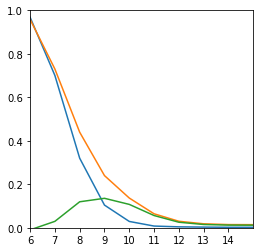

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
counts_random=np.array(counts_random,dtype="float16")
counts=np.array(counts,dtype="float16")
ax.plot(counts_random/N)
ax.plot(counts/N)
ax.plot((counts-counts_random)/N)
ax.set_xticks(range(9))
ax.set_xticklabels(range(6,16))
ax.set_xlim((0,9))
ax.set_ylim((0,1))
plt.show()

What happens in the strain with reduced dCas9 concentration?

In [13]:
flt=(data["ntargets"]==1) & (data["coding"]==False) & (data["essential"]==False) & (data["tree_pred18"]>threshold)
contigency=pd.crosstab(data[flt].off_target_pos9.notnull(),data[flt].fit75<threshold,margins=True)
print(contigency)
contigencyF=contigency/np.array([contigency.loc["All"].values]*3)
print(contigencyF)

falsePos, truePos=contigencyF.values[1,:2]
print("\nEstimate of the proportion of guides producing an unexpectedly \
strong fitness defect that can be explained by a likely off-target: {0:.0%} ({1:4.0f} guides)".format(truePos-falsePos,(truePos-falsePos)*contigency.values[2,1]))


print("\nFisher exact test p-value: {:.4}".format(stats.fisher_exact(contigency.values[:2,:2])[1]))

fit75            False  True    All
off_target_pos9                    
False            31676   226  31902
True              3866   287   4153
All              35542   513  36055
fit75               False      True       All
off_target_pos9                              
False            0.891227  0.440546  0.884815
True             0.108773  0.559454  0.115185
All              1.000000  1.000000  1.000000

Estimate of the proportion of guides producing an unexpectedly strong fitness defect that can be explained by a likely off-target: 45% ( 231 guides)

Fisher exact test p-value: 7.96e-134


guide                                           ACGCGGGTTGTGGACCTGGC
gene                                                            bioC
essential                                                      False
pos                                                           810908
ori                                                                +
coding                                                         False
fit18                                                        -6.7067
fit75                                                       -6.47683
ntargets                                                           1
seq                TAAATACACCCACGTACTGGACGCGGGTTGTGGACCTGGCTGGATG...
tree_pred18                                                 -1.15328
off_target_pos9                                              2964170
Name: ACGCGGGTTGTGGACCTGGC, dtype: object


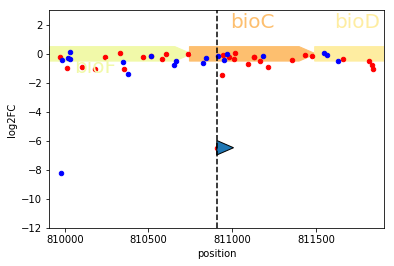

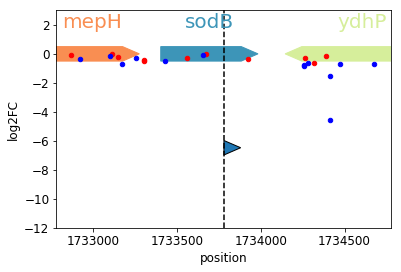

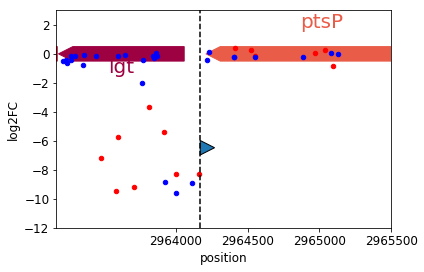

In [14]:
TbioC="ACGCGGGTTGTGGACCTGGC"
print(data.loc[TbioC])
res=crUtils.off_targets(TbioC,9)
for ori,pos in res:
    fig, ax = plt.subplots()
    ax.axvline(x=pos,ls="--",c="k")
    ax.arrow(pos,data.loc[TbioC,"fit75"],ori-0.5,0,head_width=1,head_length=100)
    crUtils.plot_pos(pos-1000,pos+1000,data,"fit75",ax=ax)
    plt.show()